# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на новые тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Перед нами стоит задача построить модель с максимально большим значением *accuracy*. Необходимо довести долю правильных ответов по крайней мере до 0.75.

## <b>Введение</b>  
В данном проекте необходимо построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

В распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Необходимо построить модель с максимально большим значением *accuracy* для задачи классификации, которая выберет подходящий тариф. Предобработка данных была проведена ранее. Доля правильных ответов должна быть не менее 0.75.

Для этого <i>[изучим исходные](#intro)</i> данные. <i>[Разобъем](#split)</i> их на на три выборки (обучающую, тестовую и валидационную). Проведем <i>[исследование моделей](#research)</i> и <i>[проверим лучшую](#test)</i> на тестовой выборке.

## Откройте и изучите файл <a id='intro'></a>

Импортируем библиотеки.

In [71]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm

Откроем файл и сохраним в переменной data.

In [72]:
data = pd.read_csv('/content/users_behavior.csv')

Выведем общую информацию о датасете.

In [73]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Проверим на наличие пропусков и явных дубликатов.

In [74]:
data.isna().sum()

calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

In [75]:
data.duplicated().sum()

0

Датасет содержит 5 столбцов и 3214 строк. Строки с пропущенными значениями отсутствуют. У столбца `messages` тип float, при этом значения в этом столбце не могут быть дробными, изменим тип на int.

In [76]:
data['messages'] = data['messages'].astype('int')

Выведем основные характеристики и первые пять строк датасета.


In [77]:
data.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


Стандартное отклонение значительно отличается от среднего, что говорит нам о сильном разбросе значений во всех столбцах, , кроме столбца `messages`, У которого эти значения достаточно близки. При этом значение среднего значения и медиан во всех столбцах кроме `messages` практически совпадают (некоторые пользователи отправляют значительно больше сообщений, чем другие).
Также, стоит отметить, что пользователей тарифа "Смарт" значительно больше, чем тирифа "Ультра". (Среднее значение в данном столбце - 0.306472)

In [78]:
data.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83,19915.42,0
1,85.0,516.75,56,22696.96,0
2,77.0,467.66,86,21060.45,0
3,106.0,745.53,81,8437.39,1
4,66.0,418.74,1,14502.75,0


Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:

- *сalls* — количество звонков,
- *minutes* — суммарная длительность звонков в минутах,
- *messages* — количество sms-сообщений,
- *mb_used* — израсходованный интернет-трафик в Мб,
- *is_ultra* — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

Построим хитмэп для корреляции значений датасета.

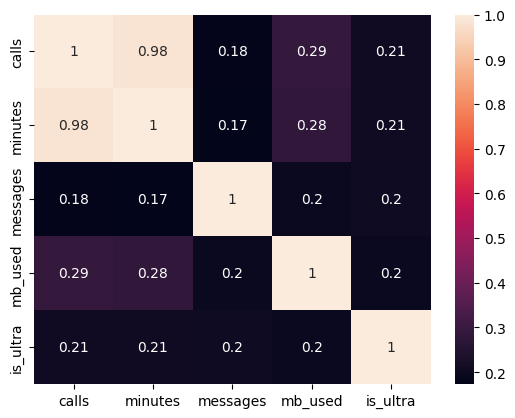

In [79]:
sns.heatmap(data.corr(), annot=True);

У столбцов `cals` и `minutes` очень сильное значение корреляции. Частичная мультиколлинеарность приводит к неустойчивости оценок значений параметров. Неустойчивость выражается в увеличении статистической неопределенности — дисперсии оценок. Конкретные результаты оценки могут сильно различаться для разных выборок несмотря на то, что выборки однородны.

Удалим столбец `calls`.

In [80]:
data = data.drop(['calls'], axis=1)

Проверим датасет на сбалансированность классов в таргете.

In [81]:
class_counts = data['is_ultra'].value_counts()

# Вывод информации о сбалансированности
total_samples = len(data)
for class_label, count in class_counts.items():
    percentage = (count / total_samples) * 100
    print(f"Класс {class_label}: {count} записей, {percentage:.2f}% от общего числа.")

# Рассчитаем, являются ли классы сбалансированными
threshold = 0.1  # 10% разница в долях считается приемлемой
min_percentage = (1 - threshold) * (1 / len(class_counts))
max_percentage = (1 + threshold) * (1 / len(class_counts))

balanced = all(min_percentage <= (count / total_samples) <= max_percentage for count in class_counts)

print("Классы сбалансированы." if balanced else "Классы несбалансированы.")

Класс 0: 2229 записей, 69.35% от общего числа.
Класс 1: 985 записей, 30.65% от общего числа.
Классы несбалансированы.


### <b>Вывод</b>

Датасет содеожит информацию о количестве и продолжительности звонков, количестве смс и мб трафика по 3214 клиентам, а также выбранный тариф.   Пропуски и явные дубликаты отсутсвуют.Количество пользователей тарифа "Смарт" значительно больше, чем тарифа "Ультра".  
Для исключения влияния мультиколлинеарности из датасета удален столбец `calls`, т.к. коэффциент корреляции для него и столбца `minutes` составляет 0,98.  
Целевой класс несбалансированн. Необходимо учесть при разделении на выборки.   
Перейдем к подготовке данных к исследованию моделей.

## Разделение данных на выборки<a id='split'></a>

Разделим датасет, выделив признак отдельно.

In [82]:
data_features = data.drop(['is_ultra'], axis=1)
data_target = data['is_ultra']

Разобъем данные на три выборки - обучающую (60%), валидационную (20%) и тестовую (20%).

In [83]:
(train_data_features, test_data_features,
 train_data_target, test_data_target) = train_test_split(data_features, data_target,
                                                         test_size=0.4,
                                                         random_state=12345,
                                                         stratify=data_target)

In [84]:
(test_data_features, valid_data_features,
 test_data_target, valid_data_target) = train_test_split(test_data_features, test_data_target,
                                                         test_size=0.5,
                                                         random_state=12345,
                                                         stratify=test_data_target)

В следующем разделе используем GridSearch. Поэтому разделим данные на две выборки обучающую и тестовую (4:1).

In [85]:
(train_grid_features, test_grid_features,
 train_grid_target, test_grid_target) = train_test_split(data_features, data_target,
                                                         test_size=0.2,
                                                         random_state=12345,
                                                         stratify=data_target)

Проверим корректность разделения

In [86]:
print(f'Размер обучающей выборки равен: признаки - {train_data_features.shape[0]}, целевой признак {train_data_target.shape[0]}.')
print(f'Размер валидационной выборки равен: признаки - {valid_data_features.shape[0]}, целевой признак {valid_data_target.shape[0]}.')
print(f'Размер тестовой выборки равен: признаки - {test_data_features.shape[0]}, целевой признак {test_data_target.shape[0]}.')

Размер обучающей выборки равен: признаки - 1928, целевой признак 1928.
Размер валидационной выборки равен: признаки - 643, целевой признак 643.
Размер тестовой выборки равен: признаки - 643, целевой признак 643.


## Исследуйте модели<a id='research'></a>

Исследуем три модели обучения -  решающее дерево, случайный лес и логистическая регрессия.

### Решающее дерево

In [87]:
%%time
best_model_dt = None
best_result_dt = 0
best_depth_dt = 0
train_score_dt = []
valid_score_dt = []
for depth in range(1, 51):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(train_data_features, train_data_target)
    train_score_dt.append(model.score(train_data_features, train_data_target))
    prediction_valid_dt = model.predict(valid_data_features)
    result = accuracy_score(valid_data_target, prediction_valid_dt)
    valid_score_dt.append(result)
    if result > best_result_dt:
        best_model_dt = model
        best_result_dt = result
        best_depth_dt = depth
print(f'Лучшая доля правильных ответов - {best_result_dt} при глубине дерева {best_depth_dt}')

Лучшая доля правильных ответов - 0.8009331259720062 при глубине дерева 10
CPU times: user 734 ms, sys: 988 µs, total: 735 ms
Wall time: 743 ms


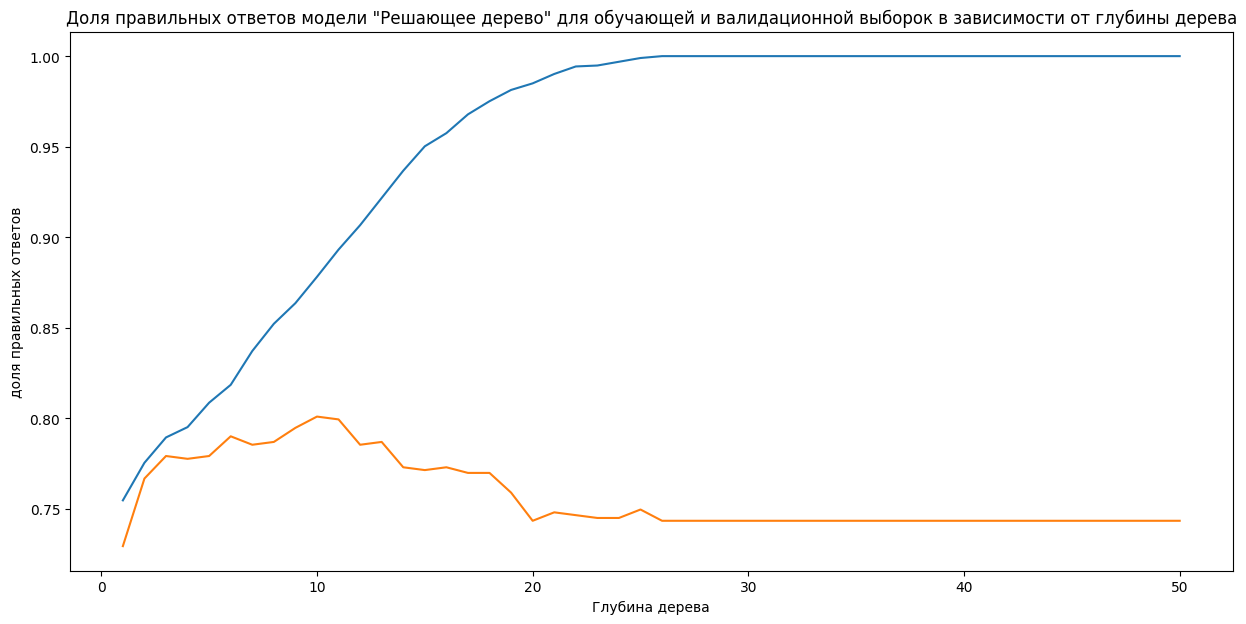

In [88]:
scale_dt = [i for i in range(1, 51)]
fig, ax = plt.subplots(figsize=(15,7))
ax.set_title('Доля правильных ответов модели "Решающее дерево" для обучающей и валидационной выборок в зависимости от глубины дерева')
ax.set_xlabel('Глубина дерева')
ax.set_ylabel('доля правильных ответов')

ax.plot(scale_dt, train_score_dt, label='Обучающая выборка');
ax.plot(scale_dt, valid_score_dt, label='Валидационная выборка');

<div class="alert alert-info">
На графике заметно несколько пиков постепенно возрастающих значений доли правильных ответов при глубине деревьев 3, 6 и достигает максимального значения 0,8 при глубине дерева 10, после чего доля правильных ответов модели начинает снижаться. </div>

Построим tree-plot для визуализации принятия решений решающим деревом.

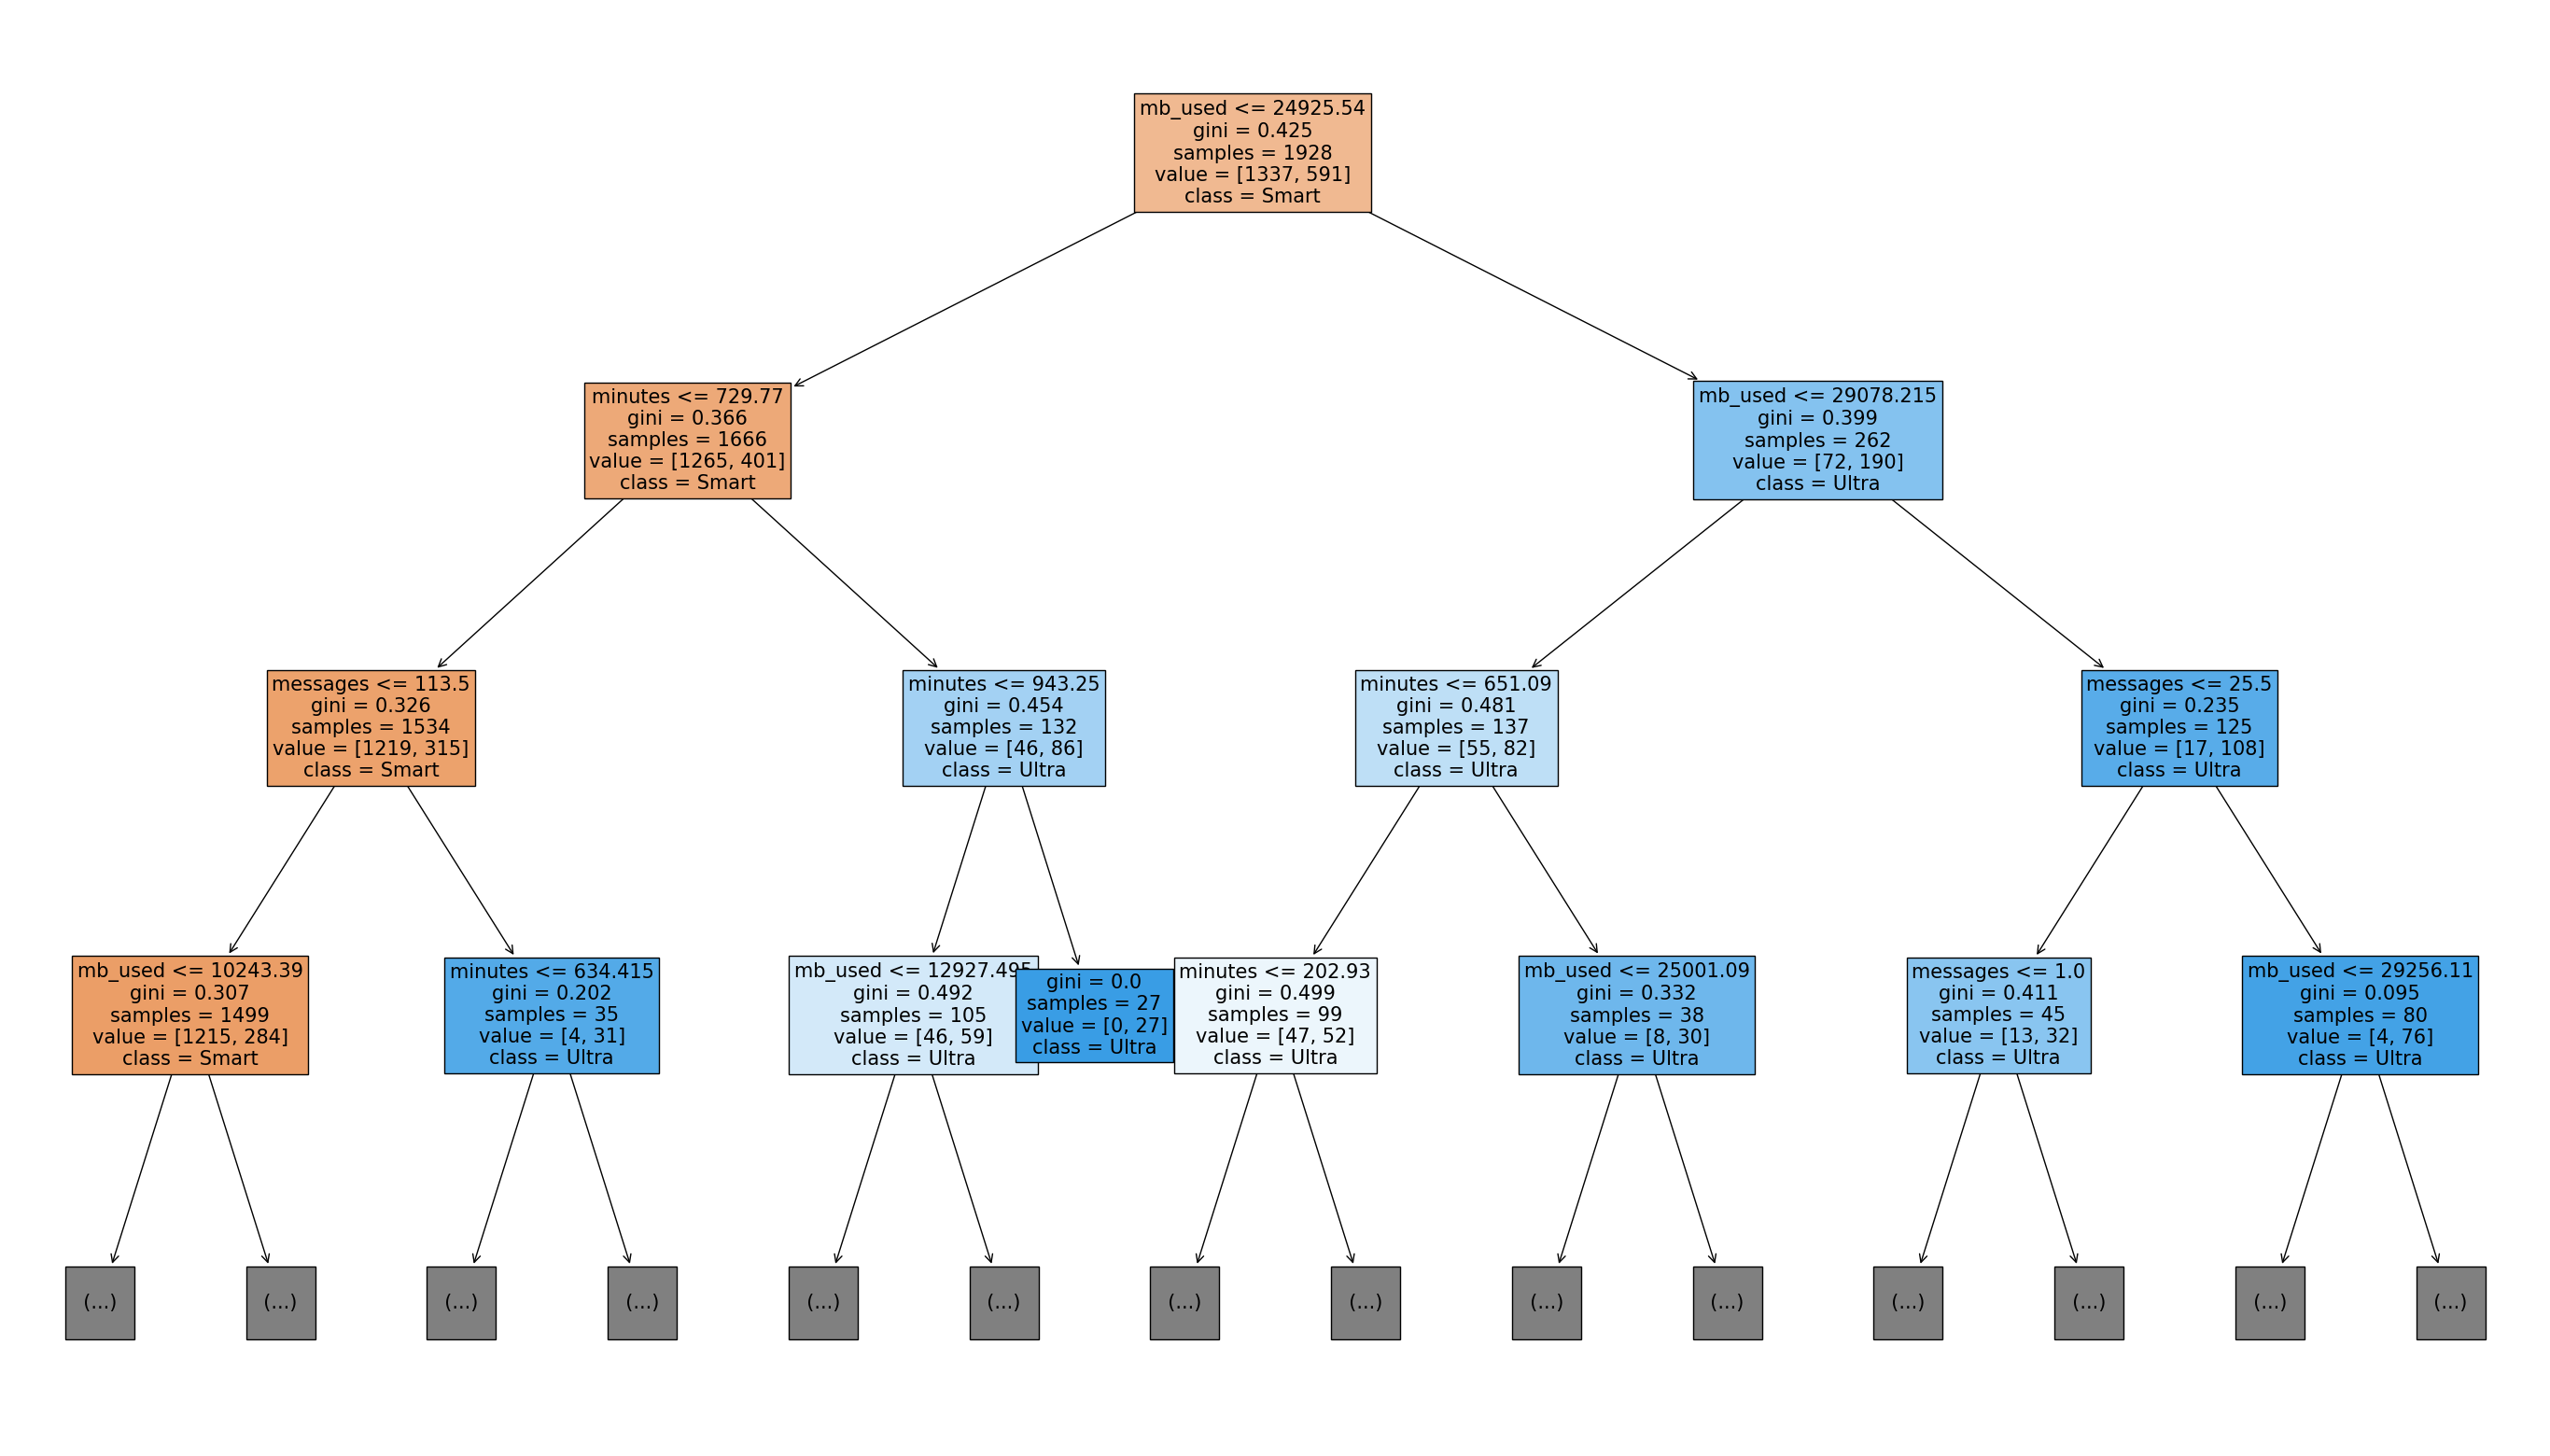

In [89]:
fig = plt.figure(figsize=(35,20))
_ = tree.plot_tree(best_model_dt,
               feature_names=train_data_features.columns.values,
               class_names=['Smart','Ultra'],
               filled=True,
               fontsize = 15,
               max_depth = 3)

### Случайный лес

In [90]:
%%time
best_model_rf = None
best_result_rf = 0
best_est_rf = 0
best_depth_rf = 0
train_score_rf = []
valid_score_rf = []
for est in tqdm(range(1, 51)):
    for depth in range(1, 51):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(train_data_features, train_data_target)
        train_score_rf.append(model.score(train_data_features, train_data_target))
        prediction_valid_rf = model.predict(valid_data_features)
        result = accuracy_score(valid_data_target, prediction_valid_rf)
        valid_score_rf.append(result)
        if result > best_result_rf:
            best_model_rf = model
            best_result_rf = result
            best_depth_rf = depth
            best_est_rf = est
print(f'Лучшая доля правильных ответов - {round(best_result_rf, 3)} при глубине дерева {best_depth_rf} и количестве деревьев {best_est_rf}.')

100%|██████████| 50/50 [04:56<00:00,  5.93s/it]

Лучшая доля правильных ответов - 0.84 при глубине дерева 13 и количестве деревьев 42.
CPU times: user 4min 52s, sys: 947 ms, total: 4min 53s
Wall time: 4min 56s


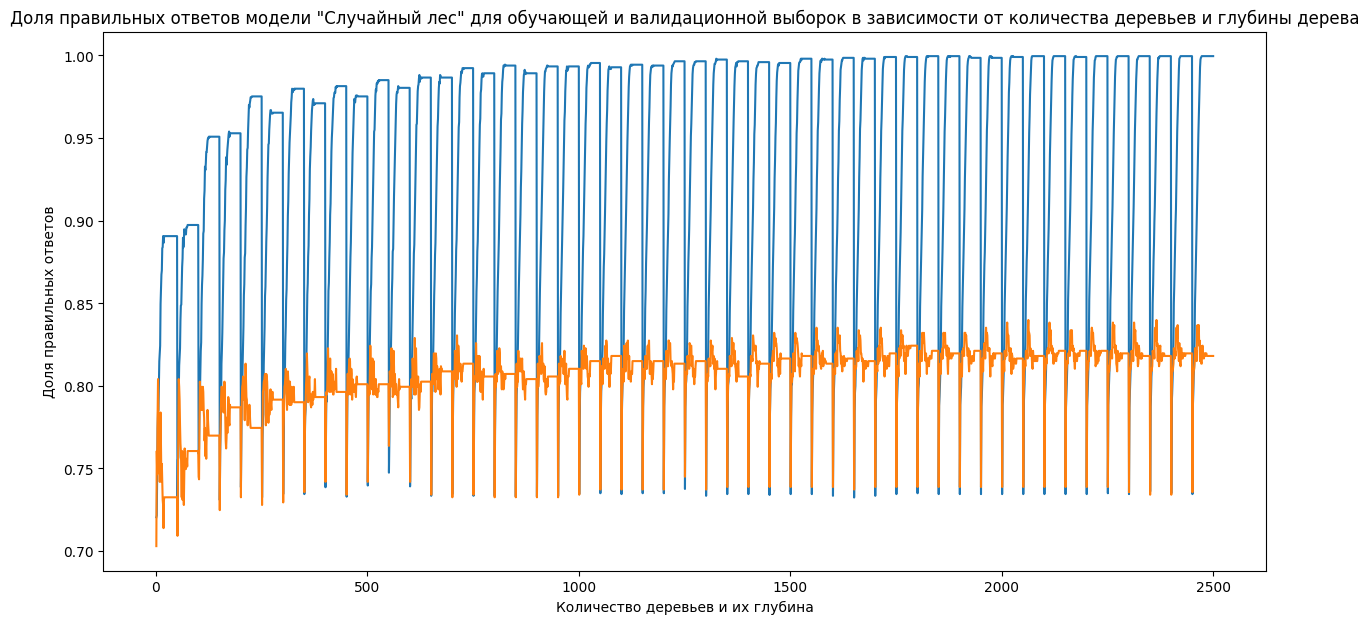

In [91]:
scale_rf = [i for i in range(1, 2501)]
fig, ax = plt.subplots(figsize=(15,7))
ax.set_title('Доля правильных ответов модели "Случайный лес" для обучающей и валидационной выборок в зависимости от количества деревьев и глубины дерева')
ax.set_xlabel('Количество деревьев и их глубина')
ax.set_ylabel('Доля правильных ответов')

ax.plot(scale_rf, train_score_rf, label='Обучающая выборка');
ax.plot(scale_rf, valid_score_rf, label='Валидационная выборка');


В данном слечае модель не переобучается, как в дереве решений, но скорость выполнения операции существенно ниже.

### Grid Search для случайного леса

Обучим модель случайного метода применяя GridSearch для подбора гиперпараметров.  
Так как в предыдущем способе модель обучали на значениях в промежутке от 1 до 50, в этот раз используем значения гиперпараметров, выходящие за эти пределы.

In [92]:
%%time

search_param = {
    'n_estimators': [10, 25, 30, 50, 100, 150, 180, 200, 251, 310, 500, 1000],
    'max_depth' : [i for i in range(1, 26)]
}
model_gs = RandomForestClassifier(random_state=12345)
GS = GridSearchCV(estimator = model_gs,
                 param_grid = search_param)

GS.fit(train_grid_features, train_grid_target)

CPU times: user 22min 8s, sys: 4.01 s, total: 22min 12s
Wall time: 22min 23s


GridSearchCV(estimator=RandomForestClassifier(random_state=12345),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25],
                         'n_estimators': [10, 25, 30, 50, 100, 150, 180, 200,
                                          251, 310, 500, 1000]})

In [93]:
print(f'Лучшие параметры - {GS.best_params_}, лучшая оценка - {round(GS.best_score_, 3)}.')

Лучшие параметры - {'max_depth': 8, 'n_estimators': 150}, лучшая оценка - 0.803.


### Логистическая регрессия

In [94]:
model_lr = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)
model_lr.fit(train_data_features, train_data_target)
prediction_valid_lr = model_lr.predict(valid_data_features)
result_lr = accuracy_score(valid_data_target, prediction_valid_lr)
print(f'Лучшая доля правильных ответов - {round(result_lr, 3)}.')

Лучшая доля правильных ответов - 0.711.


<b>Вывод</b>

Наибольшая доля правильных ответов у модели случайного леса (0,8398) при глубине дерева 13 и количестве деревьев 42.

## Проверка модели на тестовой выборке<a id='test'></a>

Проверим модели на тестовой выборке.

In [95]:
prediction_test_rf = best_model_rf.predict(test_data_features)
result_test_rf = accuracy_score(test_data_target, prediction_test_rf)
print(f'Доля правильных ответов случайного леса - {result_test_rf}')

Доля правильных ответов случайного леса - 0.8055987558320373


<b>Вывод</b>

На тестовой выборке доля правильных ответов модели случайного леса составила 0,805599, тем самым удалость превысить целевое значение точности 0,75.

Попробуем улучшить результат обучив модель на двух выборках сразу - валидационной и тренировочной. И затем проверим на тестовой.

In [96]:
model_rf = RandomForestClassifier(random_state=12345, n_estimators=42, max_depth=13)
model_rf.fit(pd.concat([train_data_features, valid_data_features]), pd.concat([train_data_target, valid_data_target]))
prediction_valid_rf = model_rf.predict(test_data_features)
result_rf = accuracy_score(test_data_target, prediction_valid_rf)

print(f'Лучшая Доля правильных ответов - {round(result_rf, 3)}.')

Лучшая Доля правильных ответов - 0.815.


Удалось увеличить долю правильных ответов до 0,815.

## Проверка модели на адекватность

Проверим адекватность выбранной модели с помощью Dummy-модели, которая предсказывает наиболее часто встречающийся класс. Для сравнения выберем стратегии `most_frequent` и `uniform`.

In [97]:
frequent_clf = DummyClassifier(strategy='most_frequent').fit(train_data_features, train_data_target)
frequent_predict = frequent_clf.predict(valid_data_features)

print(f'Точность Dummy-модели со стратегией most_frequent - {frequent_clf.score(test_data_features, test_data_target)}')

Точность Dummy-модели со стратегией most_frequent - 0.6936236391912908


In [98]:
uniform_clf =  DummyClassifier(strategy='uniform').fit(train_data_features, train_data_target)
uniform_predict = uniform_clf.predict(valid_data_features)

print(f'Точность Dummy-модели со стратегией uniform - {uniform_clf.score(test_data_features, test_data_target)}')

Точность Dummy-модели со стратегией uniform - 0.505443234836703


Dummy-модели со стратегией `most_frequent` удалось достичь точности 0.706, что меньше, чем у исследованных и обученных моделей дерева решений и случайного леса, но на одном уровне с моделью логистической регрессии.

Считаем, что тест на адекватность пройден.


## Вывод
<br>В рамках проекта было необходимо решить задачу классификации, предложив пользователям тариф сотовой связи на основании имеющихся данных. </br>
<br>Предварительная обработка данных не проводилась, т.к. была выполнена ранее. Однако при проверке был выявлен высокий коэффициент корреляции у параметров `calls` и `minutes`. Поэтому столбец `calls` был удален.</br>
<br>Для решения задачи классификации были протестированы три модели - Решающее дерево(DT), Случайный лес(RF) и Логистическая регрессия(LR). Максимальное значение доли правильных ответов у модели RF - 0,8398 при количестве деоевьев 42 и максимальной глубине 13. Но стоит отметить, что время обучения модели значительно больше, чем у других моделей. У модели DT доля правтльных ответов чуть хуже - 0,801 при глубине делева 10. У LR самый низкий показатель 0,7107. Для проверки работы на тестовой выборке была выбрана модель Случайного леса (RF). </br>
<br>При проверке модели на тестовой выборке модель достигла значения доли правильных ответов в 0,8056. При попытке повторного обучения модели на обучающей и вылидационной выборках и дальнейшей проверке на тестовой удалось увеличитьт долю правильных ответов до 0,815.</br>
<br>Также, получившиеся результаты сравнили с Dummy-моделью, доля правильных ответов которой составила 0,6936, что значительно меньше, чем у обученной нами модели. Считаем, что проверка на адекватность пройдена.</br>